In [1]:

import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
import sys
import numpy as np
import tensorflow as tf
sys.path.append('c:/python310/lib/site-packages/tensorflow_privacy/')

from privacy.analysis import compute_dp_sgd_privacy


def clip_grad(grad, C):
    return grad/np.max([1, np.linalg.norm(grad)/C])

def add_grad_noise(grad, sigma, C):
    return grad + np.random.normal(0, sigma, grad.shape)

# Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Preprocess
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]


In [5]:


def plot(losses, test_accs, train_accs):
    fig, ax1 = plt.subplots()
    ax1.plot(losses, label="loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax2 = ax1.twinx()
    ax2.plot(test_accs, label="test accuracy", color="red")
    ax2.plot(train_accs, label="train accuracy", color="green")
    ax2.set_ylabel("Accuracy")
    fig.legend()
    plt.savefig("loss_acc.png")
    plt.show()

def get_accuracy(x, y, w, b):
    scores = np.dot(x, w.T) + b
    probs = 1 / (1 + np.exp(-scores))
    y_pred = np.argmax(probs, axis=1)
    accuracy = np.mean(y_pred == np.argmax(y, axis=1))
    return accuracy

def compute_epsilon(batch_size, delta, sigma, iterations):
    eps = compute_dp_sgd_privacy.compute_dp_sgd_privacy(
        n=60000,
        batch_size=batch_size,
        noise_multiplier=sigma,
        epochs=iterations,
        delta=delta)
    return eps[0]
    

def logistic_regression_sgd(X, y, learning_rate, num_epochs, batch_size, do_dp=False, C=0.5, sigma=0.5, delta=1e-5, graph_acc=False):
    N, D = X.shape
    K = y.shape[1]
    w = np.zeros((K, D))
    b = np.zeros(K)
    
    losses = np.zeros(num_epochs)
    test_accs = np.zeros(num_epochs)
    train_accs = np.zeros(num_epochs)
    epsilons = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        # Shuffle the data
        perm = np.random.permutation(N)
        X = X[perm]
        y = y[perm]

        loss_avg = 0
        # Process the data in batches
        for i in range(0, N, batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]

            # Forward pass
            scores = np.dot(X_batch, w.T) + b
            probs = 1 / (1 + np.exp(-scores))
            loss = -1/batch_size * \
                np.sum(y_batch * np.log(probs) + (1-y_batch) * np.log(1-probs))

            # Backward pass
            dscores = 1/batch_size * (probs - y_batch)
            grad_w = np.dot(dscores.T, X_batch)
            grad_b = np.sum(dscores, axis=0)

            if do_dp:
                grad_w = clip_grad(grad_w, C)
                grad_w = add_grad_noise(grad_w, sigma, C)
                grad_b = clip_grad(grad_b, C)
                grad_b = add_grad_noise(grad_b, sigma, C)

            # Update weights
            w -= learning_rate * grad_w
            b -= learning_rate * grad_b
            loss_avg += loss

        # Print loss every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: loss = {loss:.6f}")
        if graph_acc:
            test_accs[epoch] = get_accuracy(x_test, y_test, w, b)
            train_accs[epoch] = get_accuracy(x_train, y_train, w, b)
            losses[epoch] = loss_avg/(N/batch_size)
        if do_dp:
            epsilons[epoch] = compute_epsilon(batch_size, delta, sigma, epoch+1)
    # if graph_acc:
        # plot(losses, test_accs, train_accs)
    # if do_dp:
    #     plt.plot(epsilons)
    #     plt.xlabel("Epoch")
    #     plt.ylabel("Epsilon")
        # plt.savefig("epsilon_sigma_"+str(sigma)+".png")
        # plt.show()
    return w, b, epsilons, test_accs


In [20]:

sigmas = [0.1, 0.5, 1, 2, 5, 10]
epsilons = []
testaccs = []
for s in sigmas:
    w, b, eps, testacc = logistic_regression_sgd(x_train, y_train, learning_rate=0.01,
                               num_epochs=50, batch_size=600, do_dp=True, graph_acc=True, sigma=s)
    epsilons.append(eps)
    testaccs.append(testacc)


Epoch 0: loss = 3.546131


Epoch 10: loss = 1.434001


Epoch 20: loss = 1.319570


Epoch 30: loss = 1.212867


Epoch 40: loss = 1.130907


Epoch 0: loss = 3.555721


Epoch 10: loss = 1.766817


Epoch 20: loss = 1.526964


Epoch 30: loss = 1.403322


Epoch 40: loss = 1.407858


Epoch 0: loss = 4.117461


Epoch 10: loss = 2.488265


Epoch 20: loss = 2.339016


Epoch 30: loss = 2.407889


Epoch 40: loss = 2.361061


Epoch 0: loss = 6.604730


Epoch 10: loss = 5.588062


Epoch 20: loss = 6.186551


Epoch 30: loss = 6.247036


Epoch 40: loss = 6.166750


C:\Users\Julian\AppData\Local\Temp\ipykernel_20400\2693192685.py:58: RuntimeWarning: divide by zero encountered in log
  np.sum(y_batch * np.log(probs) + (1-y_batch) * np.log(1-probs))
C:\Users\Julian\AppData\Local\Temp\ipykernel_20400\2693192685.py:58: RuntimeWarning: invalid value encountered in multiply
  np.sum(y_batch * np.log(probs) + (1-y_batch) * np.log(1-probs))


Epoch 0: loss = 15.094167


Epoch 10: loss = 25.048493


Epoch 20: loss = nan


Epoch 30: loss = nan


Epoch 40: loss = nan


Epoch 0: loss = nan


Epoch 10: loss = nan


Epoch 20: loss = nan


Epoch 30: loss = nan


Epoch 40: loss = nan


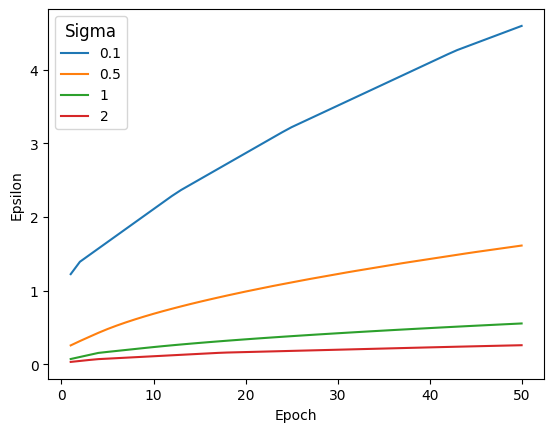

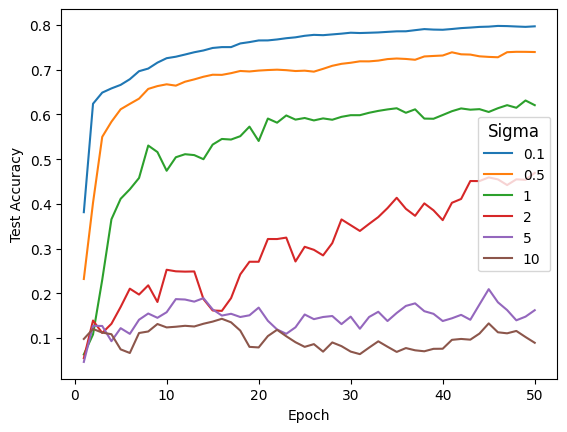

Accuracy: 0.0891


In [21]:
# plot epochs vs epsilon
for i in range(2, len(sigmas)):
    plt.plot(np.arange(1, 51), epsilons[i], label=sigmas[i])
plt.xlabel("Epoch")
plt.ylabel("Epsilon")
legend = plt.legend(sigmas)
legend.set_title('Sigma', prop={'size': 12})
plt.show()
for i in range(len(sigmas)):
    plt.plot(np.arange(1, 51), testaccs[i], label=sigmas[i])
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
legend = plt.legend(sigmas)
legend.set_title('Sigma', prop={'size': 12})
plt.show()

# Evaluate the model on the test set
accuracy = get_accuracy(x_test, y_test, w, b)
print(f"Accuracy: {accuracy:.4f}")
